In [1]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tensorflow import keras
import segmentation_models as sm
from keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()


Segmentation Models: using `keras` framework.


In [2]:
import tensorflow as tf

In [71]:
import tensorflow as tf
print(tf.version.VERSION)

2.6.0


In [3]:
root_directory = r'C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai'

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai
C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1
C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\images
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\images/image_part_001.jpg
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\images/image_part_002.jpg
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\images/image_part_003.jpg
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\images/image_part_004.jpg
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\images/image_part_005.jpg
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\images/image_part_006.jpg
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\images/image_part_007.jpg
Now patchifying image: C:\Users\Kamya\Documents

C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 7\masks
C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 8
C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 8\images
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 8\images/image_part_001.jpg
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 8\images/image_part_002.jpg
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 8\images/image_part_003.jpg
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 8\images/image_part_004.jpg
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 8\images/image_part_005.jpg
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 8\images/image_part_006.jpg
Now patchifying image: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 8\images/image_part_007.jpg
Now patchifying image: C:\Users\Ka

In [4]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 

Now patchifying mask: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\masks/image_part_001.png
Now patchifying mask: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\masks/image_part_002.png
Now patchifying mask: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\masks/image_part_003.png
Now patchifying mask: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\masks/image_part_004.png
Now patchifying mask: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\masks/image_part_005.png
Now patchifying mask: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\masks/image_part_006.png
Now patchifying mask: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\masks/image_part_007.png
Now patchifying mask: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\masks/image_part_008.png
Now patchifying mask: C:\Users\Kamya\Documents\Research\Pragyan Drone\dubai\Tile 1\masks/image_part_009.png
Now patchifying mask: C:\Use

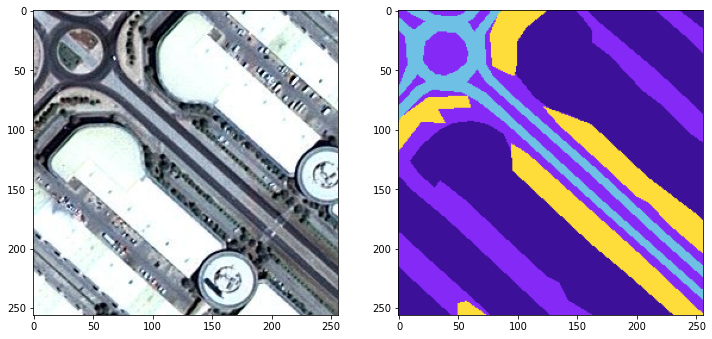

In [5]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()


In [6]:
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask


60


In [7]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

Unique labels in label dataset are:  [0 1 2 3 4 5]


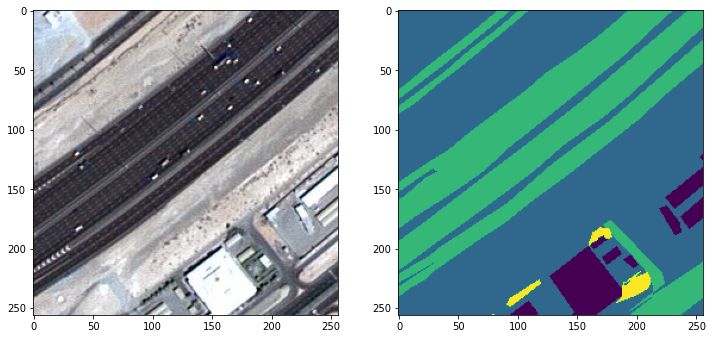

In [8]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [9]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


In [65]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [11]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


In [12]:
metrics=['accuracy', jacard_coef]


In [13]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [14]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

NameError: name 'multi_unet_model' is not defined

In [20]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())


history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=40,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_102 (ZeroPadding (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_102[0][0]         
____________________________________________________________________________________________

Epoch 1/40
66/66 [==============================] - 338s 5s/step - loss: 0.9125 - accuracy: 0.6874 - jacard_coef: 0.3830 - val_loss: 1217.0969 - val_accuracy: 0.1580 - val_jacard_coef: 0.0877
Epoch 2/40
66/66 [==============================] - 326s 5s/step - loss: 0.6272 - accuracy: 0.7911 - jacard_coef: 0.5217 - val_loss: 3.4239 - val_accuracy: 0.1445 - val_jacard_coef: 0.0842
Epoch 3/40
66/66 [==============================] - 327s 5s/step - loss: 0.5760 - accuracy: 0.8088 - jacard_coef: 0.5562 - val_loss: 1.6478 - val_accuracy: 0.5364 - val_jacard_coef: 0.2946
Epoch 4/40
66/66 [==============================] - 319s 5s/step - loss: 0.5300 - accuracy: 0.8216 - jacard_coef: 0.5809 - val_loss: 2.0038 - val_accuracy: 0.5387 - val_jacard_coef: 0.2616
Epoch 5/40
66/66 [==============================] - 307s 5s/step - loss: 0.5164 - accuracy: 0.8257 - jacard_coef: 0.5913 - val_loss: 1.7741 - val_accuracy: 0.5364 - val_jacard_coef: 0.3159
Epoch 6/40
66/66 [==============================] - 

In [14]:
model_resnet_backbone.save('mymodel.h5')

NameError: name 'model_resnet_backbone' is not defined

In [22]:
model_resnet_backbone.save('models/satellite_standard_unet_100epochs_7May2021.hdf5')

In [14]:
from keras.models import load_model
model = load_model("models\satellite_standard_unet_100epochs_7May2021.hdf5",
                   custom_objects={'dice_loss_plus_2focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.60331017


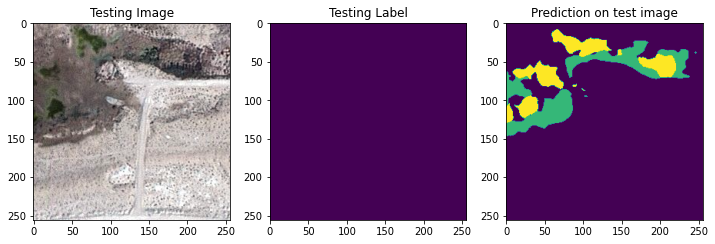

In [15]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [18]:
# import libraries
from vidgear.gears import CamGear
import cv2

stream = CamGear(source='https://youtu.be/rw7bxTqkYYs', stream_mode = True, logging=True).start() # YouTube Video URL as input

# infinite loop
while True:
    
    frame = stream.read()
    # read frames

    # check if frame is None
    if frame is None:
        #if True break the infinite loop
        break
    
    # do something with frame here
    
    cv2.imshow("Output Frame", frame)
    frame = cv2.resize(frame,(256,256))
    test_img_input=np.expand_dims(frame, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    predicted_img_show=np.array(predicted_img, dtype=np.uint8)
    #cv2.imshow("Segment", predicted_img_show)

    
    # Show output window

    key = cv2.waitKey(1) & 0xFF
    # check for 'q' key-press
    if key == ord("q"):
        #if 'q' key-pressed break out
        break

cv2.destroyAllWindows()
# close output window

# safely close video stream.
stream.stop()

11:38:16 ::    Helper     :: WARNING  :: GStreamer not found!
11:38:16 ::    Helper     ::  DEBUG   :: Selecting `best` resolution for streams.
11:38:16 ::    CamGear    ::   INFO   :: Verifying Streaming URL using yt-dlp backend. Please wait...
11:38:18 ::    CamGear    ::   INFO   :: [Backend] :: Streaming URL is fully supported. Available Streams are: [144p, 240p, 360p, 480p, 720p, 1080p, best, worst]
11:38:18 ::    CamGear    :: WARNING  :: Livestream URL detected. It is advised to use GStreamer backend(`cv2.CAP_GSTREAMER`) with it.
11:38:18 ::    CamGear    ::  DEBUG   :: Using `best` resolution for streaming.
11:38:18 ::    CamGear    ::  DEBUG   :: YouTube source ID: `rw7bxTqkYYs`, Title: `FLYING OVER PARADISE (4K UHD) Amazing Beautiful Nature Scenery & Relaxing Music - 4K Video Ultra HD 2022-03-19 11:38`, Quality: `best`
11:38:18 ::    CamGear    ::  DEBUG   :: Enabling Threaded Queue Mode for the current video source!
11:41:40 ::    CamGear    ::  DEBUG   :: Terminating proces